<a href="https://colab.research.google.com/github/samyar112/EfficientNet_B0_Based-Crop-Disease-Detection-Plant-Doctor/blob/main/EfficientNet_B0_Based_Crop_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%bash
pip install --quiet torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
pip install --quiet scikit-learn matplotlib pandas pillow tqdm
echo 'Finished installing dependencies.'

Finished installing dependencies.


In [ ]:
import os
import shutil
from google.colab import userdata

# Setup Environment
os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')

target_root = 'data/raw'
final_dataset_path = os.path.join(target_root, 'PlantVillage')
zip_path = os.path.join(target_root, 'plantvillage-dataset.zip')

# Clean Start
if os.path.exists(target_root):
    shutil.rmtree(target_root)
os.makedirs(target_root, exist_ok=True)

# Download Dataset
print("Downloading dataset from Kaggle...")
!kaggle datasets download abdallahalidev/plantvillage-dataset -p "{target_root}" --force

print("Unzipping...")
!unzip -q "{zip_path}" -d "{target_root}"

# Reorganize Structure
# The dataset extracts into: data/raw/plantvillage dataset/[color, grayscale, segmented]
extracted_base = os.path.join(target_root, 'plantvillage dataset')
color_source = os.path.join(extracted_base, 'color')

if os.path.exists(color_source):
    print(f"Found original color images at: {color_source}")

    # Move 'color' folder to be our final 'data/raw/PlantVillage'
    shutil.move(color_source, final_dataset_path)
    print(f"Moved to: {final_dataset_path}")

    # Validate Count
    total_images = sum([len(files) for r, d, files in os.walk(final_dataset_path)])
    print(f"Total Images: {total_images} (Expected ~54,305)")

    # 6. Cleanup Junk
    # Delete the zip file and the leftover folder (grayscale/segmented)
    os.remove(zip_path)
    shutil.rmtree(extracted_base)
    print("Cleanup complete: Removed zip and grayscale/segmented folders.")

else:
    print("Error: Could not find 'color' folder. Check data/raw content manually.")
    print("Contents:", os.listdir(target_root))


Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
 93% 1.91G/2.04G [00:01<00:00, 1.61GB/s]
100% 2.04G/2.04G [00:01<00:00, 1.66GB/s]
Unzipping...
Found original color images at: data/raw/plantvillage dataset/color
Moved to: data/raw/PlantVillage
Total Images: 54305 (Expected ~54,305)
Cleanup complete: Removed zip and grayscale/segmented folders.


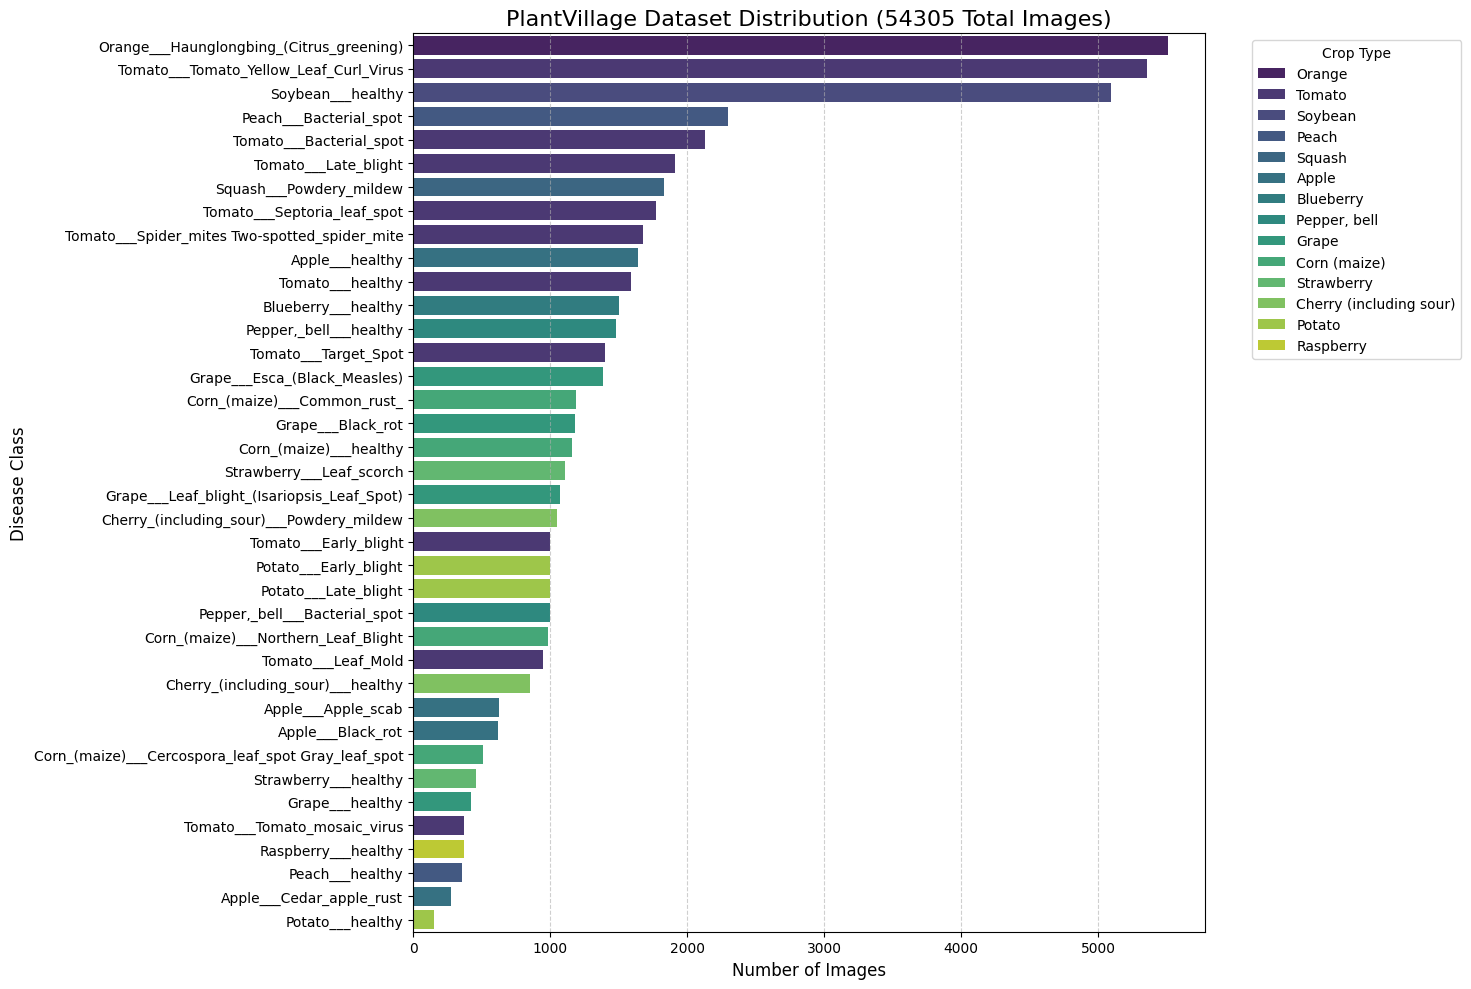

Top 5 Most Common Classes:
                                   Class  Count
Orange___Haunglongbing_(Citrus_greening)   5507
  Tomato___Tomato_Yellow_Leaf_Curl_Virus   5357
                       Soybean___healthy   5090
                  Peach___Bacterial_spot   2297
                 Tomato___Bacterial_spot   2127


In [ ]:
#Exploratory Data Analysis
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Setup Path
data_dir = 'data/raw/PlantVillage'

# Scan Data
if os.path.exists(data_dir):
    class_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])

    data = []
    for cls in class_names:
        cls_path = os.path.join(data_dir, cls)
        # Count only valid image files
        count = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

        # Parse the name "Crop___Disease"
        parts = cls.split('___')
        crop = parts[0].replace('_', ' ')
        condition = parts[1].replace('_', ' ') if len(parts) > 1 else 'Unknown'

        data.append({'Class': cls, 'Count': count, 'Crop': crop, 'Condition': condition})

    # Create DataFrame
    df = pd.DataFrame(data).sort_values('Count', ascending=False)

    # Plotting
    plt.figure(figsize=(15, 10))

    # Create a bar plot
    sns.barplot(data=df, x='Count', y='Class', hue='Crop', dodge=False, palette='viridis')

    plt.title(f'PlantVillage Dataset Distribution ({sum(df["Count"])} Total Images)', fontsize=16)
    plt.xlabel('Number of Images', fontsize=12)
    plt.ylabel('Disease Class', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.legend(title='Crop Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    plt.show()

    print("Top 5 Most Common Classes:")
    print(df[['Class', 'Count']].head().to_string(index=False))

else:
    print(f"Error: Could not find folder at {data_dir}")


Run this line only if you have the data set set up already

In [ ]:
import os

# Create base folders used by the rest of the notebook
os.makedirs('data/raw', exist_ok=True)
os.makedirs('data/splits', exist_ok=True)
os.makedirs('experiments', exist_ok=True)
os.makedirs('gradcam_outputs', exist_ok=True)

print('Created base folders: data/raw, data/splits, experiments, gradcam_outputs')

# Verify the dataset is ready
if os.path.exists('data/raw/PlantVillage'):
    print("Dataset confirmed at data/raw/PlantVillage")
else:
    print("Warning: data/raw/PlantVillage is missing. Did the Kaggle download finish?")


Created base folders: data/raw, data/splits, experiments, gradcam_outputs
Dataset confirmed at data/raw/PlantVillage


In [ ]:
import os
import glob
import time
import json

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import StepLR

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    confusion_matrix,
)

from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torchvision.models import (
    resnet50, ResNet50_Weights,
    vgg16, VGG16_Weights,
    efficientnet_b0, EfficientNet_B0_Weights,
)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)


Using device: cuda


Create Train/Validation/Test Splits

In [ ]:
import os
import glob
import pandas as pd
from sklearn.model_selection import train_test_split

def create_splits(
    data_root='data/raw/PlantVillage',
    output_dir='data/splits',
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    seed=42,
):
    """Create stratified train/val/test splits and save as CSV files."""
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, 'Ratios must sum to 1.'

    image_paths = []
    labels = []

    if not os.path.exists(data_root):
        print(f"Error: Data root '{data_root}' does not exist.")
        return

    class_names = sorted(
        [d for d in os.listdir(data_root) if os.path.isdir(os.path.join(data_root, d))]
    )
    print(f'Found {len(class_names)} classes.')

    for cls in class_names:
        cls_dir = os.path.join(data_root, cls)
        # Case-insensitive search for images
        for ext in ('*.jpg', '*.JPG', '*.jpeg', '*.JPEG', '*.png', '*.PNG'):
            for img_path in glob.glob(os.path.join(cls_dir, ext)):
                image_paths.append(img_path)
                labels.append(cls)

    df = pd.DataFrame({'path': image_paths, 'label': labels})
    print(f'Total images found: {len(df)}')

    if len(df) < 10000:
        print("WARNING: Found very few images. Check if folders contain files!")
        return

    # Split Train vs (Val + Test)
    train_df, temp_df = train_test_split(
        df,
        test_size=(1.0 - train_ratio),
        stratify=df['label'],
        random_state=seed,
    )

    # Split Val vs Test
    val_size = val_ratio / (val_ratio + test_ratio)
    val_df, test_df = train_test_split(
        temp_df,
        test_size=(1.0 - val_size),
        stratify=temp_df['label'],
        random_state=seed,
    )

    os.makedirs(output_dir, exist_ok=True)
    train_df.to_csv(os.path.join(output_dir, 'train.csv'), index=False)
    val_df.to_csv(os.path.join(output_dir, 'val.csv'), index=False)
    test_df.to_csv(os.path.join(output_dir, 'test.csv'), index=False)

    print('Saved splits to', output_dir)
    print(f'Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}')

# Run
create_splits()


Found 38 classes.
Total images found: 54305
Saved splits to data/splits
Train: 38013, Val: 8146, Test: 8146


In [ ]:
# AUGMENTATION & NORMALIZATION DEFINITIONS
import torchvision.transforms as T
from PIL import Image
import numpy as np

IMG_SIZE = 224
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

data_transforms = {
    'train': T.Compose([
        T.Resize((IMG_SIZE, IMG_SIZE)),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomVerticalFlip(p=0.5),
        T.RandomRotation(degrees=30),
        T.ColorJitter(brightness=0.2, contrast=0.2),
        T.ToTensor(),
        T.Normalize(MEAN, STD)
    ]),
    'val': T.Compose([
        T.Resize((IMG_SIZE, IMG_SIZE)),
        T.ToTensor(),
        T.Normalize(MEAN, STD)
    ]),
    'test': T.Compose([
        T.Resize((IMG_SIZE, IMG_SIZE)),
        T.ToTensor(),
        T.Normalize(MEAN, STD)
    ]),
}

print("Augmentation transforms defined.")

# SANITY CHECK
# Let's create a fake random image and pass it through the 'train' transform
# to ensure the shapes and values come out correct.
dummy_img = Image.fromarray(np.random.randint(0, 255, (500, 500, 3), dtype=np.uint8))
transformed_tensor = data_transforms['train'](dummy_img)

print("\n--- Sanity Check ---")
print(f"Input Image Size: {dummy_img.size}")
print(f"Output Tensor Shape: {transformed_tensor.shape} (Should be [3, 224, 224])")
print(f"Output Mean: {transformed_tensor.mean():.4f} (Should be near 0)")
print(f"Output Std: {transformed_tensor.std():.4f} (Should be near 1)")
print("Status: Transforms are working correctly!")


Augmentation transforms defined.

--- Sanity Check ---
Input Image Size: (500, 500)
Output Tensor Shape: torch.Size([3, 224, 224]) (Should be [3, 224, 224])
Output Mean: -0.1442 (Should be near 0)
Output Std: 0.8053 (Should be near 1)
Status: Transforms are working correctly!


3. Model Definitions (VGG16, ResNet50, EfficientNet-B0)

In [ ]:
from torchvision.models import (
    resnet50, ResNet50_Weights,
    vgg16, VGG16_Weights,
    efficientnet_b0, EfficientNet_B0_Weights,
)

def create_model(model_name: str, num_classes: int, pretrained: bool = True):
    model_name = model_name.lower()

    if model_name == 'resnet50':
        weights = ResNet50_Weights.IMAGENET1K_V1 if pretrained else None
        model = resnet50(weights=weights)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)

    elif model_name == 'vgg16':
        weights = VGG16_Weights.IMAGENET1K_V1 if pretrained else None
        model = vgg16(weights=weights)
        in_features = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(in_features, num_classes)

    elif model_name == 'efficientnet_b0':
        weights = EfficientNet_B0_Weights.IMAGENET1K_V1 if pretrained else None
        model = efficientnet_b0(weights=weights)
        in_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_features, num_classes)

    else:
        raise ValueError(f'Unknown model_name: {model_name}')

    return model

print('Model factory ready.')

Model factory ready.


In [ ]:
from torch.utils.data import Dataset, DataLoader

class PlantVillageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.transform = transform
        self.classes = sorted(self.data_frame['label'].unique().tolist())
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        row = self.data_frame.iloc[idx]
        img_path = row['path']
        label_name = row['label']
        label = self.class_to_idx[label_name]

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, label

def create_dataloaders(
    splits_dir='data/splits',
    batch_size=128,
    num_workers=2,
    image_size=224
):
    temp_dataset = PlantVillageDataset(os.path.join(splits_dir, 'train.csv'))
    class_names = temp_dataset.classes

    train_ds = PlantVillageDataset(
        os.path.join(splits_dir, 'train.csv'),
        transform=data_transforms['train']
    )
    val_ds = PlantVillageDataset(
        os.path.join(splits_dir, 'val.csv'),
        transform=data_transforms['val']
    )
    test_ds = PlantVillageDataset(
        os.path.join(splits_dir, 'test.csv'),
        transform=data_transforms['test']
    )

    train_loader = DataLoader(
        train_ds, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, drop_last=True, pin_memory=True
    )
    val_loader = DataLoader(
        val_ds, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, drop_last=False, pin_memory=True
    )
    test_loader = DataLoader(
        test_ds, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, drop_last=False, pin_memory=True
    )

    print(f"DataLoaders created. Classes: {len(class_names)}")
    return train_loader, val_loader, test_loader, class_names


4. Training Utilities and Training Loop

In [ ]:
def freeze_backbone(model, model_name):
    model_name = model_name.lower()
    if model_name == 'resnet50':
        for name, param in model.named_parameters():
            if not name.startswith('fc'):
                param.requires_grad = False
    elif model_name == 'vgg16':
        for name, param in model.named_parameters():
            if not name.startswith('classifier.6'):
                param.requires_grad = False
    elif model_name == 'efficientnet_b0':
        for name, param in model.named_parameters():
            if not name.startswith('classifier'):
                param.requires_grad = False
    else:
        raise ValueError('Unknown model_name in freeze_backbone')


def get_trainable_params(model):
    return [p for p in model.parameters() if p.requires_grad]


def evaluate(model, dataloader, num_classes):
    model.eval()
    all_preds = []
    all_probs = []
    all_targets = []


    softmax = nn.Softmax(dim=1)


    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(DEVICE)
            targets = targets.to(DEVICE)


            outputs = model(images)
            probs = softmax(outputs)
            preds = torch.argmax(probs, dim=1)


            all_preds.append(preds.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())


    all_preds = np.concatenate(all_preds)
    all_probs = np.concatenate(all_probs)
    all_targets = np.concatenate(all_targets)


    acc = accuracy_score(all_targets, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_targets,
        all_preds,
        average='macro',
        zero_division=0,
    )


    try:
        roc_auc = roc_auc_score(
            all_targets,
            all_probs,
            multi_class='ovr',
            average='macro',
        )
    except ValueError:
        roc_auc = float('nan')


    cm = confusion_matrix(all_targets, all_preds)


    metrics = {
        'accuracy': float(acc),
        'macro_precision': float(precision),
        'macro_recall': float(recall),
        'macro_f1': float(f1),
        'macro_roc_auc': float(roc_auc),
        'confusion_matrix': cm.tolist(),
    }
    return metrics


def train_one_model(
    model_name,
    splits_dir='data/splits',
    output_dir='experiments',
    image_size=224,
    batch_size=128,
    num_workers=4,
    base_lr=3e-3,
    epochs_phase1=5,
    epochs_phase2=20,
    optimizer_name='adam',
):
    train_loader, val_loader, test_loader, class_names = create_dataloaders(
        splits_dir=splits_dir,
        batch_size=batch_size,
        num_workers=num_workers,
        image_size=image_size,
    )
    num_classes = len(class_names)

    exp_dir = os.path.join(output_dir, model_name)
    os.makedirs(exp_dir, exist_ok=True)

    with open(os.path.join(exp_dir, 'class_names.json'), 'w') as f:
        json.dump(class_names, f, indent=2)

    model = create_model(model_name, num_classes=num_classes, pretrained=True)
    model.to(DEVICE)

    criterion = nn.CrossEntropyLoss()

    print(f'===== Phase 1: Training classifier only ({model_name}) =====')
    freeze_backbone(model, model_name)
    params_phase1 = get_trainable_params(model)

    if optimizer_name.lower() == 'adam':
        optimizer = Adam(params_phase1, lr=base_lr)
    else:
        optimizer = SGD(params_phase1, lr=base_lr, momentum=0.9)

    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

    best_val_f1 = -1.0
    best_ckpt_path = os.path.join(exp_dir, 'best_model.pt')

    for epoch in range(1, epochs_phase1 + 1):
        model.train()
        running_loss = 0.0
        n_samples = 0
        start_time = time.time()

        for batch_idx, (images, targets) in enumerate(train_loader, start=1):
            images = images.to(DEVICE)
            targets = targets.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            n_samples += images.size(0)

            if batch_idx % 20 == 0:
                print(f'[Phase1][Epoch {epoch}] Batch {batch_idx}/{len(train_loader)} Loss: {loss.item():.4f}')

        scheduler.step()
        train_loss = running_loss / n_samples

        val_metrics = evaluate(model, val_loader, num_classes)
        val_f1 = val_metrics['macro_f1']
        elapsed = time.time() - start_time

        print(
            f'[Phase1][Epoch {epoch}/{epochs_phase1}] '
            f'Train Loss: {train_loss:.4f} | '
            f'Val Acc: {val_metrics["accuracy"]:.4f} | '
            f'Val F1: {val_f1:.4f} | Time: {elapsed:.1f}s'
        )

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), best_ckpt_path)
            print(f'  -> New best model saved (F1={best_val_f1:.4f}).')

    print(f'===== Phase 2: Fine-tuning backbone ({model_name}) =====')
    model.load_state_dict(torch.load(best_ckpt_path, map_location=DEVICE))

    for param in model.parameters():
        param.requires_grad = True

    params_phase2 = get_trainable_params(model)
    fine_tune_lr = base_lr * 0.1

    if optimizer_name.lower() == 'adam':
        optimizer = Adam(params_phase2, lr=fine_tune_lr)
    else:
        optimizer = SGD(params_phase2, lr=fine_tune_lr, momentum=0.9)

    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

    for epoch in range(1, epochs_phase2 + 1):
        model.train()
        running_loss = 0.0
        n_samples = 0
        start_time = time.time()

        for batch_idx, (images, targets) in enumerate(train_loader, start=1):
            images = images.to(DEVICE)
            targets = targets.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            n_samples += images.size(0)

            if batch_idx % 20 == 0:
                print(f'[Phase2][Epoch {epoch}] Batch {batch_idx}/{len(train_loader)} Loss: {loss.item():.4f}')

        scheduler.step()
        train_loss = running_loss / n_samples

        val_metrics = evaluate(model, val_loader, num_classes)
        val_f1 = val_metrics['macro_f1']
        elapsed = time.time() - start_time

        print(
            f'[Phase2][Epoch {epoch}/{epochs_phase2}] '
            f'Train Loss: {train_loss:.4f} | '
            f'Val Acc: {val_metrics["accuracy"]:.4f} | '
            f'Val F1: {val_f1:.4f} | Time: {elapsed:.1f}s'
        )

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), best_ckpt_path)
            print(f'  -> New best model saved (F1={best_val_f1:.4f}).')

    print('===== Final Test Evaluation =====')
    model.load_state_dict(torch.load(best_ckpt_path, map_location=DEVICE))
    test_metrics = evaluate(model, test_loader, num_classes)

    with open(os.path.join(exp_dir, 'test_metrics.json'), 'w') as f:
        json.dump(test_metrics, f, indent=2)

    print('Test metrics:', test_metrics)
    print('Saved best model to:', best_ckpt_path)

    return test_metrics

print('Training utilities ready.')



Training utilities ready.


each of us can run a model on our computer for the result cause the training might take a while

In [ ]:
import json
import torch
import torch.nn as nn
# Train VGG16 (baseline)
vgg_test_metrics = train_one_model('vgg16')

# Train ResNet50 (baseline)
resnet_test_metrics = train_one_model('resnet50')

# Train EfficientNet-B0 (proposed/advanced model)
effnet_test_metrics = train_one_model('efficientnet_b0')

DataLoaders created. Classes: 38
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:02<00:00, 245MB/s]


===== Phase 1: Training classifier only (vgg16) =====
[Phase1][Epoch 1] Batch 20/296 Loss: 1.5821
[Phase1][Epoch 1] Batch 40/296 Loss: 1.2230
[Phase1][Epoch 1] Batch 60/296 Loss: 1.1222
[Phase1][Epoch 1] Batch 80/296 Loss: 1.0174
[Phase1][Epoch 1] Batch 100/296 Loss: 0.9079
[Phase1][Epoch 1] Batch 120/296 Loss: 1.1710
[Phase1][Epoch 1] Batch 140/296 Loss: 1.1350
[Phase1][Epoch 1] Batch 160/296 Loss: 0.9799
[Phase1][Epoch 1] Batch 180/296 Loss: 1.0632
[Phase1][Epoch 1] Batch 200/296 Loss: 0.9569
[Phase1][Epoch 1] Batch 220/296 Loss: 0.8740
[Phase1][Epoch 1] Batch 240/296 Loss: 1.0321
[Phase1][Epoch 1] Batch 260/296 Loss: 0.7012
[Phase1][Epoch 1] Batch 280/296 Loss: 0.8639
[Phase1][Epoch 1/5] Train Loss: 1.1553 | Val Acc: 0.8076 | Val F1: 0.7468 | Time: 53.7s
  -> New best model saved (F1=0.7468).
[Phase1][Epoch 2] Batch 20/296 Loss: 0.9447
[Phase1][Epoch 2] Batch 40/296 Loss: 0.8497
[Phase1][Epoch 2] Batch 60/296 Loss: 1.0511
[Phase1][Epoch 2] Batch 80/296 Loss: 0.8519
[Phase1][Epoch 2]

100%|██████████| 97.8M/97.8M [00:00<00:00, 195MB/s]


===== Phase 1: Training classifier only (resnet50) =====
[Phase1][Epoch 1] Batch 20/296 Loss: 1.8674
[Phase1][Epoch 1] Batch 40/296 Loss: 1.1685
[Phase1][Epoch 1] Batch 60/296 Loss: 0.6381
[Phase1][Epoch 1] Batch 80/296 Loss: 0.6473
[Phase1][Epoch 1] Batch 100/296 Loss: 0.5949
[Phase1][Epoch 1] Batch 120/296 Loss: 0.5303
[Phase1][Epoch 1] Batch 140/296 Loss: 0.4975
[Phase1][Epoch 1] Batch 160/296 Loss: 0.2909
[Phase1][Epoch 1] Batch 180/296 Loss: 0.4339
[Phase1][Epoch 1] Batch 200/296 Loss: 0.3430
[Phase1][Epoch 1] Batch 220/296 Loss: 0.2912
[Phase1][Epoch 1] Batch 240/296 Loss: 0.4370
[Phase1][Epoch 1] Batch 260/296 Loss: 0.2785
[Phase1][Epoch 1] Batch 280/296 Loss: 0.3392
[Phase1][Epoch 1/5] Train Loss: 0.6857 | Val Acc: 0.9008 | Val F1: 0.8728 | Time: 49.9s
  -> New best model saved (F1=0.8728).
[Phase1][Epoch 2] Batch 20/296 Loss: 0.3772
[Phase1][Epoch 2] Batch 40/296 Loss: 0.3892
[Phase1][Epoch 2] Batch 60/296 Loss: 0.1827
[Phase1][Epoch 2] Batch 80/296 Loss: 0.3263
[Phase1][Epoch

100%|██████████| 20.5M/20.5M [00:00<00:00, 201MB/s]

===== Phase 1: Training classifier only (efficientnet_b0) =====


[Phase1][Epoch 1] Batch 20/296 Loss: 1.2197
[Phase1][Epoch 1] Batch 40/296 Loss: 0.8360
[Phase1][Epoch 1] Batch 60/296 Loss: 0.5956
[Phase1][Epoch 1] Batch 80/296 Loss: 0.5306
[Phase1][Epoch 1] Batch 100/296 Loss: 0.5288
[Phase1][Epoch 1] Batch 120/296 Loss: 0.3881
[Phase1][Epoch 1] Batch 140/296 Loss: 0.3220
[Phase1][Epoch 1] Batch 160/296 Loss: 0.3777
[Phase1][Epoch 1] Batch 180/296 Loss: 0.2937
[Phase1][Epoch 1] Batch 200/296 Loss: 0.4114
[Phase1][Epoch 1] Batch 220/296 Loss: 0.3706
[Phase1][Epoch 1] Batch 240/296 Loss: 0.3616
[Phase1][Epoch 1] Batch 260/296 Loss: 0.3623
[Phase1][Epoch 1] Batch 280/296 Loss: 0.2089
[Phase1][Epoch 1/5] Train Loss: 0.5654 | Val Acc: 0.9290 | Val F1: 0.9118 | Time: 48.6s
  -> New best model saved (F1=0.9118).
[Phase1][Epoch 2] Batch 20/296 Loss: 0.3414
[Phase1][Epoch 2] Batch 40/296 Loss: 0.3279
[Phase1][Epoch 2] Batch 60/296 Loss: 0.2652
[Phase1][Epoch 2] Batch 80/296 Loss: 0.2927
[Phase1][Epoch 2] Batch 100/296 Loss: 0.2997
[Phase1][Epoch 2] Batch 12

In [ ]:
def load_class_names(exp_dir):
    class_file = os.path.join(exp_dir, 'class_names.json')
    with open(class_file, 'r') as f:
        class_names = json.load(f)
    return class_names


def build_test_loader(test_csv='data/splits/test.csv', image_size=224, batch_size=1, num_workers=4):
    eval_transform = data_transforms['test']
    dataset = PlantVillageDataset(test_csv, transform=eval_transform)
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )
    return loader


def measure_inference_time(
    model_name,
    exp_dir,
    test_csv='data/splits/test.csv',
    image_size=224,
    batch_size=1,
    warmup_batches=10,
    timed_batches=50,
):
    class_names = load_class_names(exp_dir)
    num_classes = len(class_names)


    model = create_model(model_name, num_classes=num_classes, pretrained=False)
    ckpt_path = os.path.join(exp_dir, 'best_model.pt')
    model.load_state_dict(torch.load(ckpt_path, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()


    test_loader = build_test_loader(test_csv, image_size=image_size, batch_size=batch_size)


    print('Warming up...')
    with torch.no_grad():
        for i, (images, _) in enumerate(test_loader):
            if i >= warmup_batches:
                break
            images = images.to(DEVICE)
            _ = model(images)


    print('Measuring inference time...')
    n_images = 0
    start_time = time.perf_counter()
    with torch.no_grad():
        for i, (images, _) in enumerate(test_loader):
            if i >= timed_batches:
                break
            images = images.to(DEVICE)
            _ = model(images)
            n_images += images.size(0)
        if DEVICE.type == 'cuda':
            torch.cuda.synchronize()


    total_time = time.perf_counter() - start_time
    latency_per_image = total_time / n_images
    throughput = n_images / total_time


    print(f'Images processed: {n_images}')
    print(f'Total time: {total_time:.4f}s')
    print(f'Latency per image: {latency_per_image*1000:.3f} ms')
    print(f'Throughput: {throughput:.2f} images/sec')


    results = {
        'model_name': model_name,
        'images': n_images,
        'total_time_sec': total_time,
        'latency_ms_per_image': latency_per_image * 1000,
        'throughput_images_per_sec': throughput,
    }


    with open(os.path.join(exp_dir, 'inference_timing.json'), 'w') as f:
        json.dump(results, f, indent=2)


    return results


print('Inference timing utilities ready.')


Inference timing utilities ready.


Grad-CAM utilities ready.

==================== Grad-CAM for vgg16 ====================


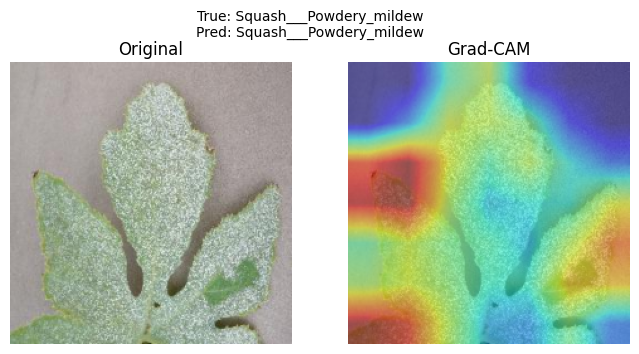

Saved Grad-CAM: gradcam_outputs/vgg16/vgg16_idx6245.png


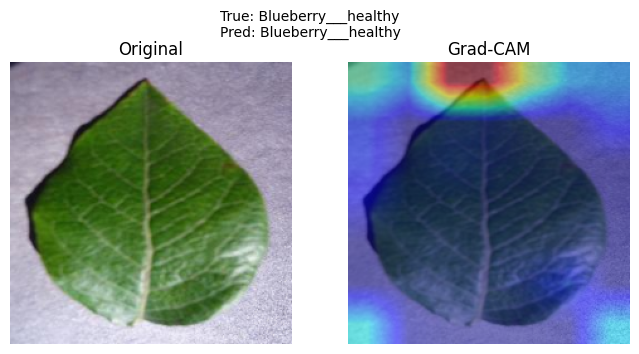

Saved Grad-CAM: gradcam_outputs/vgg16/vgg16_idx5023.png


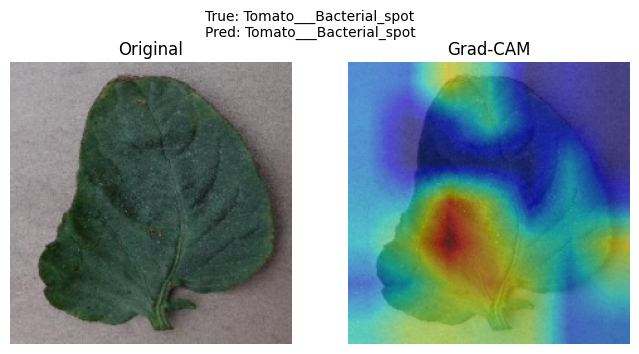

Saved Grad-CAM: gradcam_outputs/vgg16/vgg16_idx6927.png

==================== Grad-CAM for resnet50 ====================


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


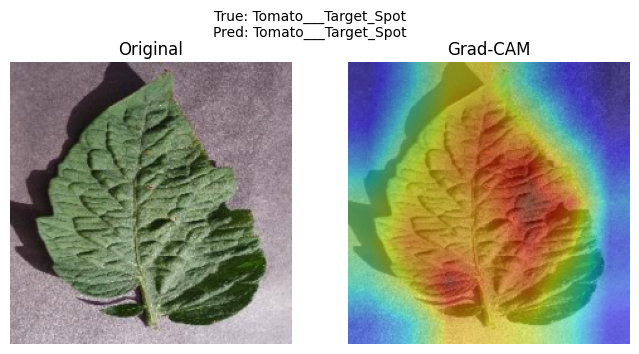

Saved Grad-CAM: gradcam_outputs/resnet50/resnet50_idx3401.png


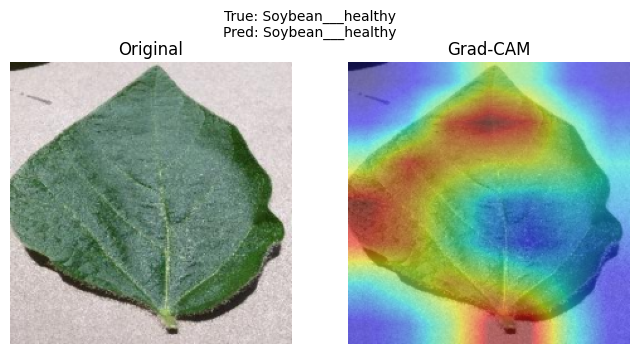

Saved Grad-CAM: gradcam_outputs/resnet50/resnet50_idx254.png


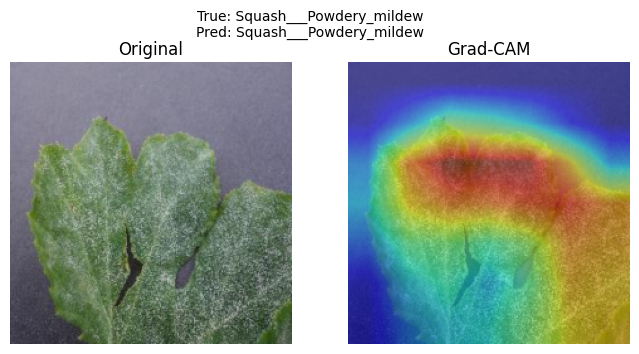

Saved Grad-CAM: gradcam_outputs/resnet50/resnet50_idx7158.png

==================== Grad-CAM for efficientnet_b0 ====================


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


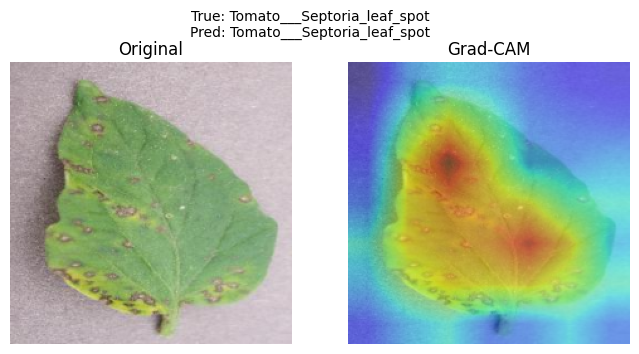

Saved Grad-CAM: gradcam_outputs/efficientnet_b0/efficientnet_b0_idx731.png


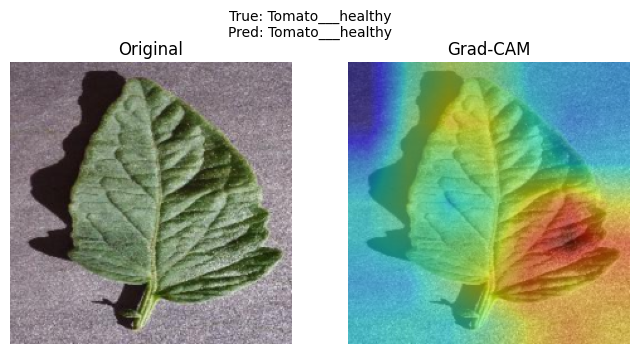

Saved Grad-CAM: gradcam_outputs/efficientnet_b0/efficientnet_b0_idx4786.png


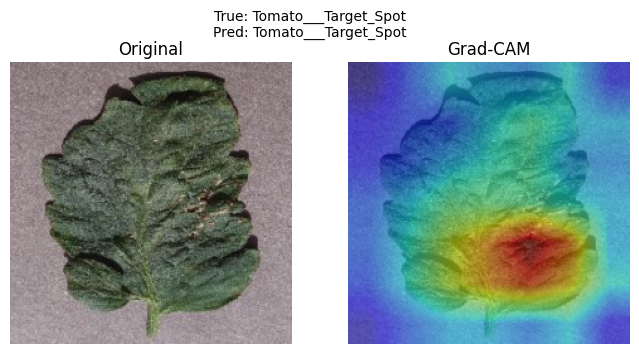

Saved Grad-CAM: gradcam_outputs/efficientnet_b0/efficientnet_b0_idx7501.png


In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.target_layer = target_layer

        self.activations = None
        self.gradients = None

        self._register_hooks()

    def _save_activation(self, module, input, output):
        self.activations = output.detach()

    def _save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def _register_hooks(self):
        self.target_layer.register_forward_hook(self._save_activation)
        self.target_layer.register_backward_hook(self._save_gradient)

    def generate(self, input_tensor, target_class=None):
        self.model.zero_grad()
        output = self.model(input_tensor)

        if target_class is None:
            target_class = torch.argmax(output, dim=1).item()

        target = output[0, target_class]
        target.backward()

        grads = self.gradients
        activations = self.activations

        weights = torch.mean(grads, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * activations, dim=1)
        cam = F.relu(cam)
        cam = cam[0].cpu().numpy()

        cam -= cam.min()
        if cam.max() > 0:
            cam /= cam.max()

        return cam

def get_target_layer(model, model_name):
    model_name = model_name.lower()
    if model_name == 'resnet50':
        return model.layer4[-1]
    elif model_name == 'vgg16':
        return model.features[-1]
    elif model_name == 'efficientnet_b0':
        return model.features[-1]
    else:
        raise ValueError(f'Unknown model_name: {model_name}')

def overlay_cam_on_image(img_tensor, cam):
    #Use MEAN and STD variables from augmentation block earlier
    mean = torch.tensor(MEAN).view(3, 1, 1)
    std = torch.tensor(STD).view(3, 1, 1)

    img = img_tensor.cpu() * std + mean
    img = torch.clamp(img, 0, 1)

    _, H, W = img.shape
    cam_t = torch.tensor(cam).unsqueeze(0).unsqueeze(0)
    cam_t = F.interpolate(cam_t, size=(H, W), mode='bilinear', align_corners=False)
    cam_resized = cam_t[0, 0].numpy()

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.title('Original')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.imshow(cam_resized, cmap='jet', alpha=0.5)
    plt.title('Grad-CAM')
    plt.axis('off')

def visualize_gradcam_for_samples(
    model_name,
    exp_dir,
    csv_path='data/splits/test.csv',
    image_size=224,
    num_samples=5,
    output_dir='gradcam_outputs',
):
    os.makedirs(output_dir, exist_ok=True)

    class_names = load_class_names(exp_dir)
    num_classes = len(class_names)

    model = create_model(model_name, num_classes=num_classes, pretrained=False)
    ckpt_path = os.path.join(exp_dir, 'best_model.pt')
    model.load_state_dict(torch.load(ckpt_path, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()

    # Use existing transforms dictionary
    eval_transform = data_transforms['test']
    dataset = PlantVillageDataset(csv_path, transform=eval_transform)

    target_layer = get_target_layer(model, model_name)
    gradcam = GradCAM(model, target_layer)

    indices = np.random.choice(len(dataset), size=min(num_samples, len(dataset)), replace=False)

    for idx in indices:
        img_tensor, label_idx = dataset[idx]
        input_tensor = img_tensor.unsqueeze(0).to(DEVICE)

        # Forward pass
        # Note: We do NOT use torch.no_grad() here because GradCAM needs gradients!
        output = model(input_tensor)
        pred_class_idx = int(torch.argmax(output, dim=1).item())

        cam = gradcam.generate(input_tensor, target_class=pred_class_idx)

        overlay_cam_on_image(img_tensor, cam)

        true_label = class_names[label_idx]
        pred_label = class_names[pred_class_idx]
        plt.suptitle(f'True: {true_label}\nPred: {pred_label}', fontsize=10)

        out_path = os.path.join(
            output_dir, f'{model_name}_idx{idx}.png'
        )
        plt.savefig(out_path, dpi=150)
        plt.show()
        print('Saved Grad-CAM:', out_path)

print('Grad-CAM utilities ready.')

# List of models to visualize
models_to_check = [
    ('vgg16', 'experiments/vgg16'),
    ('resnet50', 'experiments/resnet50'),
    ('efficientnet_b0', 'experiments/efficientnet_b0')
]

# Loop through each model and visualize 3 samples
for model_name, exp_dir in models_to_check:
    print(f"\n{'='*20} Grad-CAM for {model_name} {'='*20}")

    try:
        visualize_gradcam_for_samples(
            model_name=model_name,
            exp_dir=exp_dir,
            csv_path='data/splits/test.csv',
            num_samples=3,
            output_dir=f'gradcam_outputs/{model_name}'
        )
    except Exception as e:
        print(f"Could not run Grad-CAM for {model_name}. Error: {e}")
        print("Make sure you have finished training this model first!")


In [ ]:
import pandas as pd
import os
import json

# Run Inference Measurement for all 3 models

print("Measuring VGG16...")
vgg_stats = measure_inference_time('vgg16', 'experiments/vgg16')

print("Measuring ResNet50...")
resnet_stats = measure_inference_time('resnet50', 'experiments/resnet50')

print("Measuring EfficientNet-B0...")
effnet_stats = measure_inference_time('efficientnet_b0', 'experiments/efficientnet_b0')

# Helper to get file size
def get_model_size_mb(model_name):
    path = f'experiments/{model_name}/best_model.pt'
    if os.path.exists(path):
        return os.path.getsize(path) / (1024 * 1024) # Convert bytes to MB
    return 0.0

# Helper to get F1 score from saved JSON
def get_test_f1(model_name):
    path = f'experiments/{model_name}/test_metrics.json'
    if os.path.exists(path):
        with open(path, 'r') as f:
            data = json.load(f)
        return data.get('macro_f1', 0.0)
    return 0.0

# Build the DataFrame
all_stats = [vgg_stats, resnet_stats, effnet_stats]
models = ['vgg16', 'resnet50', 'efficientnet_b0']
data = []

for name, stats in zip(models, all_stats):
    row = {
        'Model': name,
        'Test F1 Score': get_test_f1(name),
        'Inference Latency (ms)': stats['latency_ms_per_image'],
        'Throughput (img/sec)': stats['throughput_images_per_sec'],
        'Model Size (MB)': get_model_size_mb(name)
    }
    data.append(row)

df_results = pd.DataFrame(data)

# Display
print("\n===== FINAL MODEL COMPARISON =====")
print(df_results.to_string(index=False))


Measuring VGG16...
Warming up...
Measuring inference time...
Images processed: 50
Total time: 0.2649s
Latency per image: 5.299 ms
Throughput: 188.72 images/sec
Measuring ResNet50...
Warming up...
Measuring inference time...
Images processed: 50
Total time: 0.5447s
Latency per image: 10.894 ms
Throughput: 91.79 images/sec
Measuring EfficientNet-B0...
Warming up...
Measuring inference time...
Images processed: 50
Total time: 0.6697s
Latency per image: 13.394 ms
Throughput: 74.66 images/sec

===== FINAL MODEL COMPARISON =====
          Model  Test F1 Score  Inference Latency (ms)  Throughput (img/sec)  Model Size (MB)
          vgg16       0.994615                5.298934            188.717187       512.768727
       resnet50       0.998288               10.894427             91.790052        90.277238
efficientnet_b0       0.997169               13.394028             74.660140        15.758904


Downloaded training_logs.txt
Successfully parsed data for: ['vgg16', 'resnet50', 'efficientnet_b0']


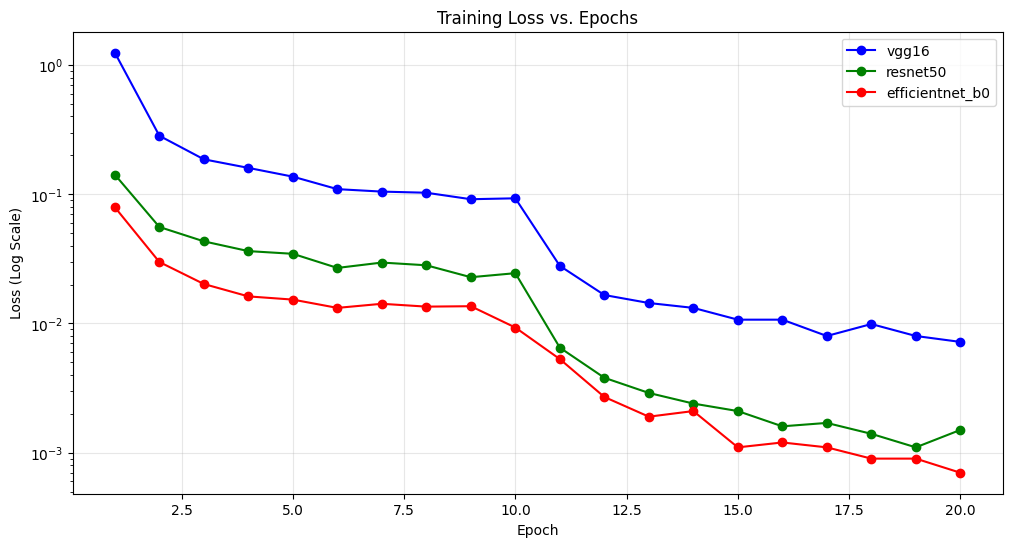

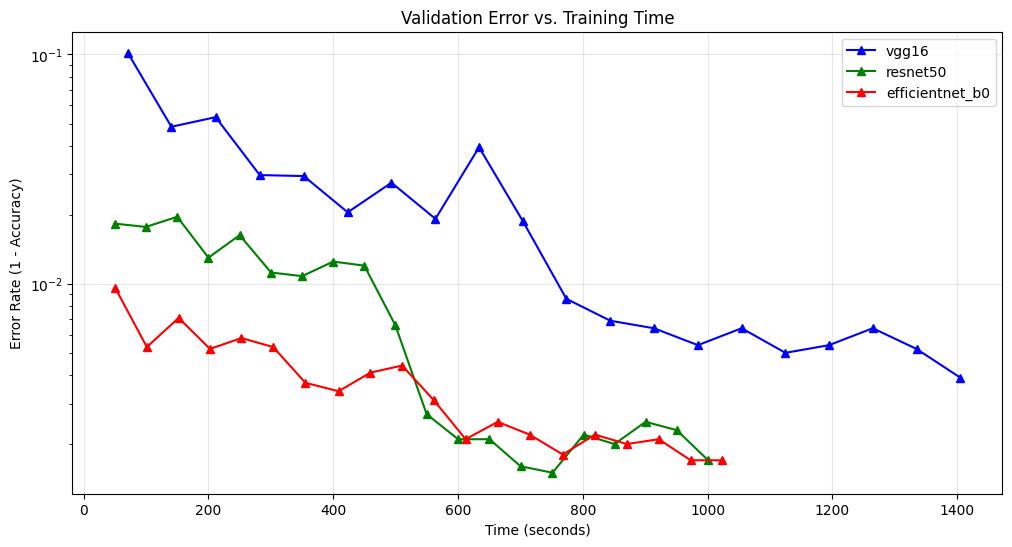

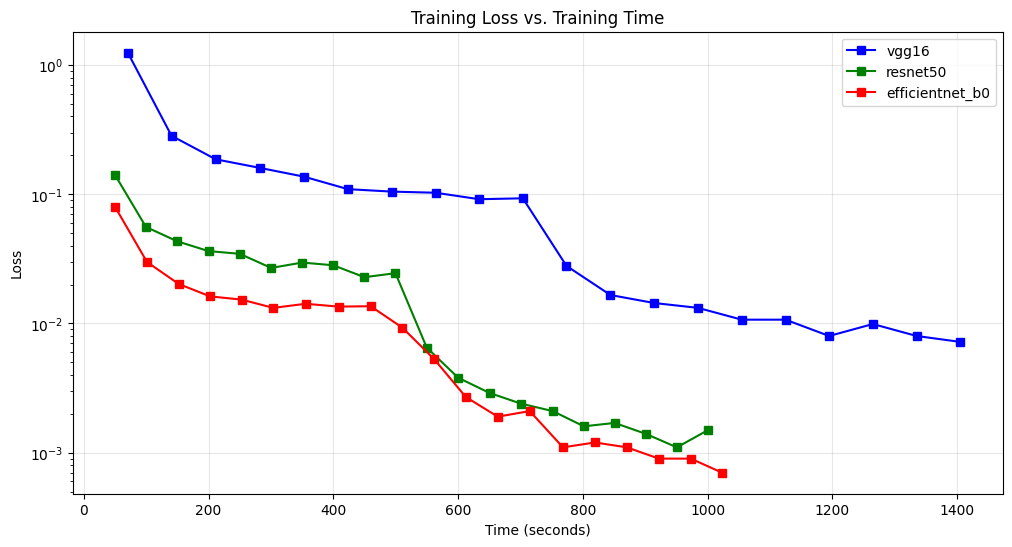

In [ ]:
import re
import matplotlib.pyplot as plt
import os

# ==========================================
# 1. DOWNLOAD FILE FROM DRIVE
# ==========================================
# This downloads the file using its ID from the link you shared
file_id = '1XlBi_UVrFc_DlhOxCXwBS2nT8YiYU5ah'
output_file = 'training_logs.txt'

# Run gdown command (standard in Colab)
if not os.path.exists(output_file):
    os.system(f'gdown {file_id} -O {output_file}')
    print(f"Downloaded {output_file}")
else:
    print(f"{output_file} already exists")

# ==========================================
# 2. PARSE LOGS
# ==========================================
def parse_logs(filename):
    data = {
        'vgg16': {'loss': [], 'acc': [], 'time': []},
        'resnet50': {'loss': [], 'acc': [], 'time': []},
        'efficientnet_b0': {'loss': [], 'acc': [], 'time': []}
    }

    with open(filename, 'r') as f:
        lines = f.readlines()

    current_model = None

    for line in lines:
        # Detect Model Section
        if "Phase 2: Fine-tuning backbone" in line:
            if "vgg16" in line: current_model = 'vgg16'
            elif "resnet50" in line: current_model = 'resnet50'
            elif "efficientnet_b0" in line: current_model = 'efficientnet_b0'
            continue

        # Extract Metrics
        if current_model and "[Phase2][Epoch" in line:
            match = re.search(r'Train Loss: ([\d.]+) \| Val Acc: ([\d.]+) .* Time: ([\d.]+)s', line)
            if match:
                data[current_model]['loss'].append(float(match.group(1)))
                data[current_model]['acc'].append(float(match.group(2)))
                data[current_model]['time'].append(float(match.group(3)))
    return data

# Parse the downloaded file
parsed_data = parse_logs(output_file)

# Check what was found
found_models = [m for m, d in parsed_data.items() if len(d['loss']) > 0]
print(f"Successfully parsed data for: {found_models}")

# ==========================================
# 3. GENERATE PLOTS
# ==========================================
models = ['vgg16', 'resnet50', 'efficientnet_b0']
colors = {'vgg16': 'blue', 'resnet50': 'green', 'efficientnet_b0': 'red'}

# --- Plot 1: Loss vs Epochs ---
plt.figure(figsize=(12, 6))
for m in models:
    if m in found_models:
        epochs = range(1, len(parsed_data[m]['loss']) + 1)
        plt.plot(epochs, parsed_data[m]['loss'], marker='o', label=m, color=colors[m])
plt.title('Training Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (Log Scale)')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- Plot 2: Test Error vs Time ---
plt.figure(figsize=(12, 6))
for m in models:
    if m in found_models:
        times = parsed_data[m]['time']
        cum_time = [sum(times[:i+1]) for i in range(len(times))]
        error = [1.0 - acc for acc in parsed_data[m]['acc']]
        plt.plot(cum_time, error, marker='^', label=m, color=colors[m])
plt.title('Validation Error vs. Training Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Error Rate (1 - Accuracy)')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- Plot 3: Train Loss vs Time ---
plt.figure(figsize=(12, 6))
for m in models:
    if m in found_models:
        times = parsed_data[m]['time']
        cum_time = [sum(times[:i+1]) for i in range(len(times))]
        plt.plot(cum_time, parsed_data[m]['loss'], marker='s', label=m, color=colors[m])
plt.title('Training Loss vs. Training Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
